- 여기서 제안된 코드는 Lee, B.교수님의 논문을 바탕으로 완성되었습니다. 참고문헌은 아래와 같습니다.

- Lee, B. (2018). Varimax Rotation and Thereafter: Tutorial on PCA Using Linear Algebra, Visualization, and Python Programming for R and Q analysis. 연구방법논총, 3(1), 79-130.

[pdf 파일 링크](https://www.researchgate.net/publication/325647424_Varimax_Rotation_and_Thereafter_Tutorial_on_PCA_Using_Linear_Algebra_Visualization_and_Python_Programming_for_R_and_Q_analysis)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from factor_analyzer import FactorAnalyzer, Rotator


class pca_varimax:
    """
    데이터 프레임 타입을 받아 들입니다.
    loading 값을 도출하기 위해서 원하는 차수를 입력하셔야 합니다.
    varimax rotate가 적용된 결과를 확인하기 위해서 varimax() 함수를 시행하셔야 합니다.
    """

    def __init__(self, x):
        self.x = x

    def pca(self):
        # 문항간 상관계수 도출
        self.numCorr = self.x.corr()
        # 고유치와 고유벡터 도출
        eVal_corr, eVec_corr = np.linalg.eig(self.numCorr)
        # 고유치의 크기가 큰 순으로 고유치 및 고유벡터 정리(argsort()[::-1]제일 큰 값부터 순서대로 데이터의 인덱스값을 출력해줌)
        idx_corr = eVal_corr.argsort()[::-1]
        self.eVal_corr = eVal_corr[idx_corr]
        eVec_corr = eVec_corr[:, idx_corr]
        # 고유치와 고유벡터 도출 # 고유치의 크기가 큰 순으로 고유치 및 고유벡터 정리 한번에
        U, S, VT = np.linalg.svd(self.numCorr)
        # 고유백터 합이 1이하인 수에 -1을 곱해준다

        def flip_vector_sign(eVec):
            # shape는 어레이의 행과 열 개수를 알려준다 .shape[0]는 열 개수
            for i in range(eVec.shape[1]):
                if(eVec[:, i].sum() < 0):
                    eVec[:, i] = -1*eVec[:, i]
            return eVec

        self.V = flip_vector_sign(VT.T)
        # 총 분산 설명
        exp = eVal_corr*100/np.sum(eVal_corr)
        accSum = np.cumsum(exp)  # 누적합
        pcNum = list(range(1, len(x.columns)+1))  # 상수항은 항시 제거되야한다.
        data = np.array([pcNum, eVal_corr, exp, accSum])
        eigenValues = pd.DataFrame(
            data.T, columns=['PC#', 'Eigenvalue', '% of Varian Exp', 'Cumulative %'])
        eigenNumbers = eigenValues.copy()
        format_mapping = {'PC#': '{:,.0f}', 'Eigenvalue': '{:,.3f}',
                          '% of Varian Exp': '{:.3f}', 'Cumulative %': '{:.3f}%'}
        
        for key, value in format_mapping.items():
            eigenValues[key] = eigenValues[key].apply(value.format)

        eachExp = eigenNumbers.iloc[:, 2]
        
        plt.figure(figsize=(6, 6))
        plt.bar(pcNum, accSum, width=0.5, color='cyan',
                alpha=0.2, label="Cumulative %")
        plt.plot(pcNum, eachExp, label="% of Variance Explained")
        plt.plot(pcNum, eachExp, 'ro', label='_nolegend_')
        plt.xlabel("Principal Components")
        plt.ylabel("% of Variance Explained")
        plt.title("% of Varianve Explained by PCs", fontsize=16)
        plt.legend(loc='upper left')
        
        print(eigenValues)

    def loading(self, n):
        try:
            eVec_corr3 = self.V[:, :n]
            eVal_corr3 = self.eVal_corr[:n]
            self.loading3 = eVec_corr3*np.sqrt(eVal_corr3)
            loading3T = self.loading3.round(n).T
            index = []
            for index_n in range(1, n+1):
                a = "PC" + str(index_n)
                index.append(a)
            loadingDF = pd.DataFrame(loading3T, index=[index], columns=[
                x.columns])
            pcScoreCoef = np.linalg.inv(self.numCorr)@(self.loading3)
            zScore = (self.x - self.x.mean())/self.x.std()
            pcScore = zScore.dot(pcScoreCoef)
            print(loadingDF.T)
            return pcScore.round(5)
        except:
            print("PCA 함수 시행이 선행되어야 합니다.")

    def varimax(self):
        try:
            fa = FactorAnalyzer(rotation=None)
            rotator = Rotator()
            a = rotator.fit(self.loading3)
            return a.rotation_, a.loadings_
        except:
            print("PCA 함수 및 loading 함수 시행이 선행되어야 합니다.")

In [2]:
filepath = 'http://bestelon.com/pca/lipset.csv'
df = pd.read_csv(filepath)
x = df.iloc[:, 1:10]

In [3]:
result = pca_varimax(x)

  PC# Eigenvalue % of Varian Exp Cumulative %
0   1      2.384          26.486      26.486%
1   2      2.015          22.393      48.879%
2   3      1.341          14.898      63.777%
3   4      1.127          12.526      76.303%
4   5      0.168           1.865      78.169%
5   6      0.732           8.136      86.305%
6   7      0.320           3.551      89.855%
7   8      0.401           4.459      94.315%
8   9      0.512           5.685     100.000%


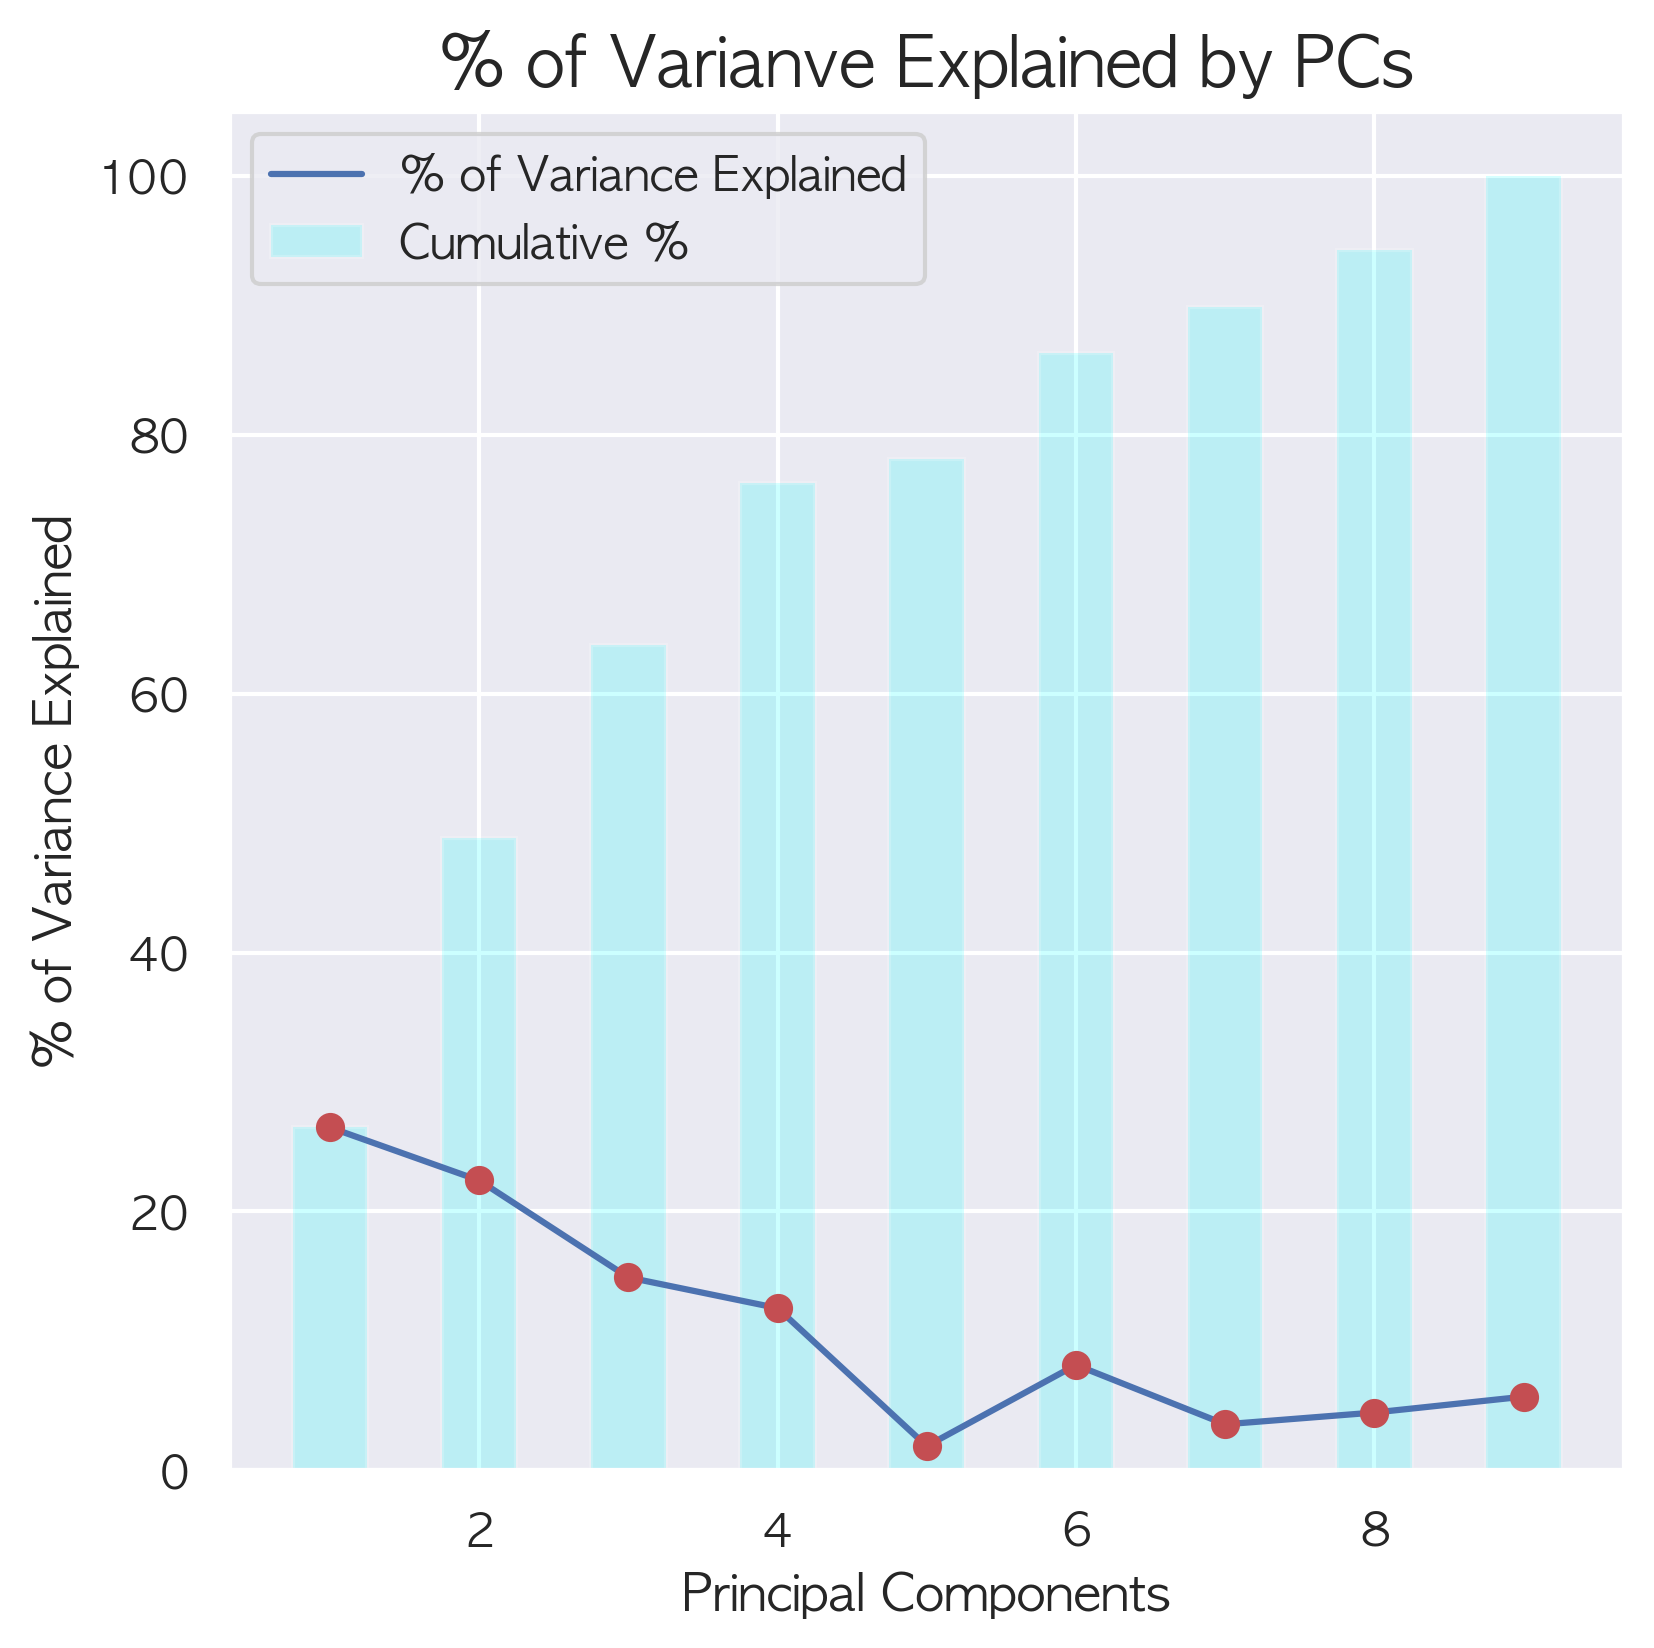

In [4]:
result.pca()

In [5]:
result.loading(3)

      PC1    PC2    PC3
v1 -0.481  0.607  0.228
v2 -0.501  0.392  0.542
v3  0.388  0.667 -0.265
v4  0.416  0.725  0.171
v5 -0.525 -0.600  0.289
v6  0.691 -0.107  0.591
v7  0.711 -0.182  0.386
v8 -0.565  0.320  0.234
v9 -0.027  0.128 -0.509


,0,1,2
0,1.55125,0.92806,-0.85854
1,-0.57445,0.23950,-0.46792
2,-0.66767,-1.45335,-0.29508
3,1.42814,0.00750,-0.73250
4,0.57579,-1.00634,1.29582
5,0.00663,0.80832,2.62408
6,-1.41590,-1.37589,-0.11324
7,-0.87942,-0.97312,-0.35451
8,0.69958,0.25283,-1.32997
9,-1.19380,-1.88593,-0.16561


In [6]:
result.varimax()

(array([[ 0.63692282,  0.52945063,  0.56036716],
        [-0.55715964,  0.81850672, -0.14007104],
        [-0.53282498, -0.22299952,  0.81631412]]),
 array([[-0.76583098,  0.19090031, -0.16829944],
        [-0.82578471, -0.0655237 ,  0.10674419],
        [ 0.01642114,  0.8107385 , -0.09294327],
        [-0.22983558,  0.77564922,  0.27115532],
        [-0.1543819 , -0.83345268,  0.02554101],
        [ 0.18452178,  0.14605752,  0.88487489],
        [ 0.3486223 ,  0.14131112,  0.73900317],
        [-0.66252588, -0.08906645, -0.17048799],
        [ 0.18284105,  0.20377209, -0.44813857]]))